In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0027-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0199-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0103-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0036-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0281-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0276-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0312-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0283-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0271-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0112-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0022-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0201-0001.jpeg
/kaggle/input/ch

## **Defining the Directories**

In [2]:
data_dir = '/kaggle/input/chest-xray-pneumonia'
train_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
print(os.listdir(train_data_dir))
print(os.listdir(test_data_dir))

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


**The images have been classified into 'Normal' and 'Pneumonia' in both training and validation directories**

## **Reading the images**

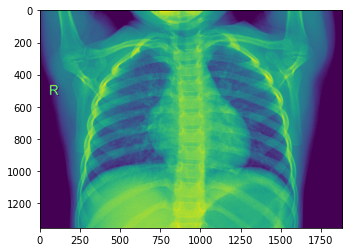

In [3]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

normal_train_images = [mpimg.imread(img_path) for img_path in glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/*')]
pneumonia_train_images = [mpimg.imread(img_path) for img_path in glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*')]
normal_test_images = [mpimg.imread(img_path) for img_path in glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/*')]
pneumonia_test_images = [mpimg.imread(img_path) for img_path in glob.glob('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/*')]


plt.imshow(normal_train_images[0])


## **Labeling the images**

In [4]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255, 
                                   rotation_range=10,
                                   zoom_range=0.2,
                                   height_shift_range=0.2,
                                   width_shift_range=0.2,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1/255)
                                   
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(150,150),
                                                    class_mode='binary',
                                                    batch_size=128)
validation_generator = val_datagen.flow_from_directory(test_data_dir,
                                                       target_size=(150,150),
                                                       batch_size=128,
                                                       class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## **Inception model**

In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
from tensorflow import keras

pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150,150,3))

for layer in pre_trained_model.layers:
    layer.trainable=False

pre_trained_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

In [6]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow import keras

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = keras.layers.Flatten()(last_output)

x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=pre_trained_model.input, outputs=x)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 20,
                    verbose = 1)

Epoch 1/20
41/41 [==============================] - 161s 4s/step - loss: 0.7690 - accuracy: 0.8376 - val_loss: 0.4252 - val_accuracy: 0.8317
Epoch 2/20
41/41 [==============================] - 160s 4s/step - loss: 0.1492 - accuracy: 0.9417 - val_loss: 0.3692 - val_accuracy: 0.8814
Epoch 3/20
41/41 [==============================] - 162s 4s/step - loss: 0.1258 - accuracy: 0.9546 - val_loss: 0.3405 - val_accuracy: 0.8894
Epoch 4/20
41/41 [==============================] - 161s 4s/step - loss: 0.1130 - accuracy: 0.9592 - val_loss: 0.3494 - val_accuracy: 0.8910
Epoch 5/20
41/41 [==============================] - 161s 4s/step - loss: 0.1131 - accuracy: 0.9582 - val_loss: 0.2330 - val_accuracy: 0.9343
Epoch 6/20
41/41 [==============================] - 161s 4s/step - loss: 0.1010 - accuracy: 0.9632 - val_loss: 0.2501 - val_accuracy: 0.9247
Epoch 7/20
41/41 [==============================] - 161s 4s/step - loss: 0.1012 - accuracy: 0.9624 - val_loss: 0.3084 - val_accuracy: 0.9038
Epoch 8/20
41

## **Plotting the accuracy and loss**

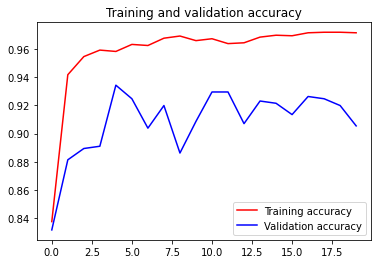

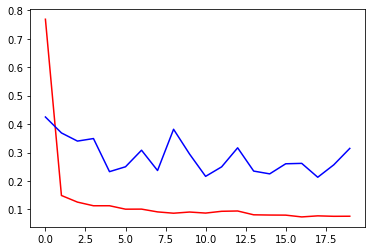

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')

plt.show()